In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
import Plotting.plotters as plotters


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

{'l1': 2, 'l2': 2, 'm': 3, 'g': 9.81, 'xa': 5, 'ya': 1}


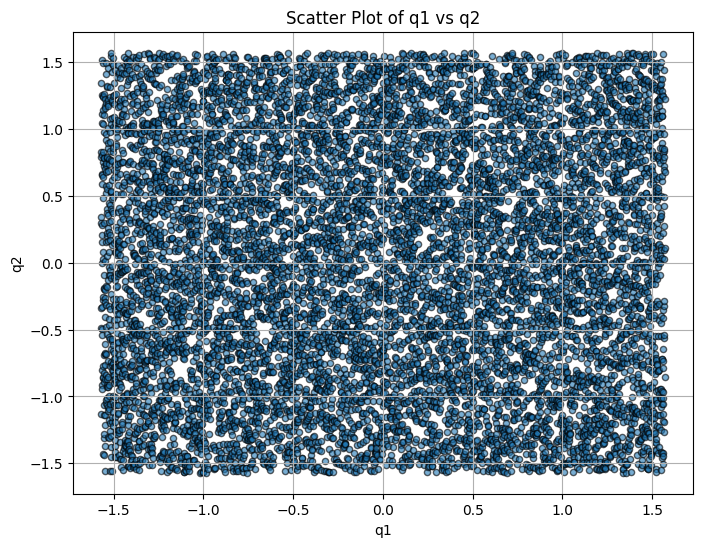

In [3]:
import numpy as np

# Number of samples
q1_low  = -torch.pi/2
q1_high = torch.pi/2
q2_low  = -torch.pi/2
q2_high = torch.pi/2
q1_d_low  = -torch.pi/2
q1_d_high = torch.pi/2
q2_d_low  = -torch.pi/2
q2_d_high = torch.pi/2


n_samples = 10000

# Generate uniformly distributed points for q1 and q2
q1 = torch.linspace(q1_low, q1_high, n_samples)
q2 = torch.linspace(q2_low, q2_high, n_samples)
q1_d = torch.linspace(q1_d_low, q1_d_high, n_samples)
q2_d = torch.linspace(q2_d_low, q2_d_high, n_samples)

idx = torch.randperm(q2.shape[0])
idx2 = torch.randperm(q1_d.shape[0])
idx3 = torch.randperm(q2_d.shape[0])

q2 = q2[idx]
q1_d = q1_d[idx2]
q2_d = q2_d[idx3]

# Stack q1 and q2 to get the 2D coordinates
points = torch.stack([q1, q2, q1_d, q2_d], axis=1)#.to(device)  # Shape will be (1000, 2)

# Plot q1 vs q2
plt.figure(figsize=(8, 6))
plt.scatter(q1.numpy(), q2.numpy(), alpha=0.6, edgecolors='k', s=20)
plt.title('Scatter Plot of q1 vs q2')
plt.xlabel('q1')
plt.ylabel('q2')
plt.grid(True)
plt.show()

In [4]:
# Use TensorDataset to create the dataset
dataset = TensorDataset(points)

# Create the DataLoader with batch size and shuffling
batch_size = 512
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True,
                        num_workers=0,
                        pin_memory=True)


# Example usage: iterate through the DataLoader
for batch in dataloader:
    #print(batch[0])
    break  # Just to show one batch

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 1)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.Sigmoid(),
            nn.Linear(4, 4),
            nn.Sigmoid(),
            nn.Linear(4, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2

    def encoder_nn(self, q):
        theta_2 = self.encoder(q)
        return theta_2, theta_2
    
    def forward(self, q):
        
        J_h_1, theta_1 = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        
        J_h_2, theta_2 = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)
        
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        
        theta = torch.stack((theta_1, theta_2), dim=1).squeeze(2)
        J_h = torch.cat((J_h_1, J_h_2), dim=1)
        J_h_ana = torch.cat((J_h_1, J_h_2_ana), dim=1)

        q_hat = self.decoder(theta)
        return(theta, J_h, q_hat, J_h_ana)

/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411251956.pth
Epoch:1, Loss:0.132814437


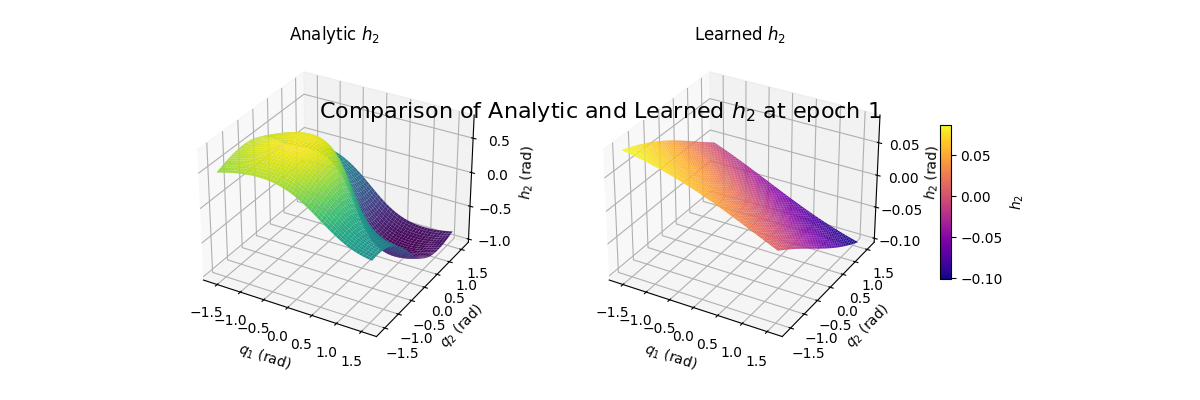

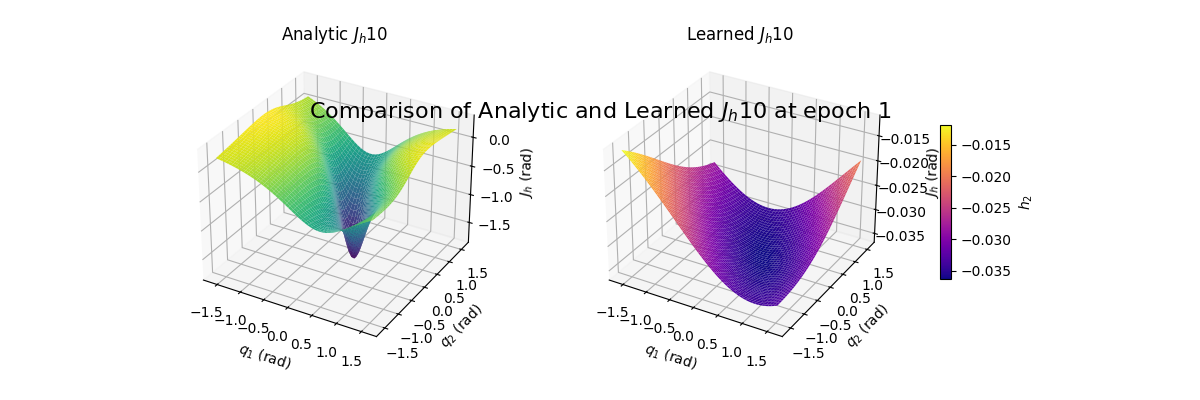

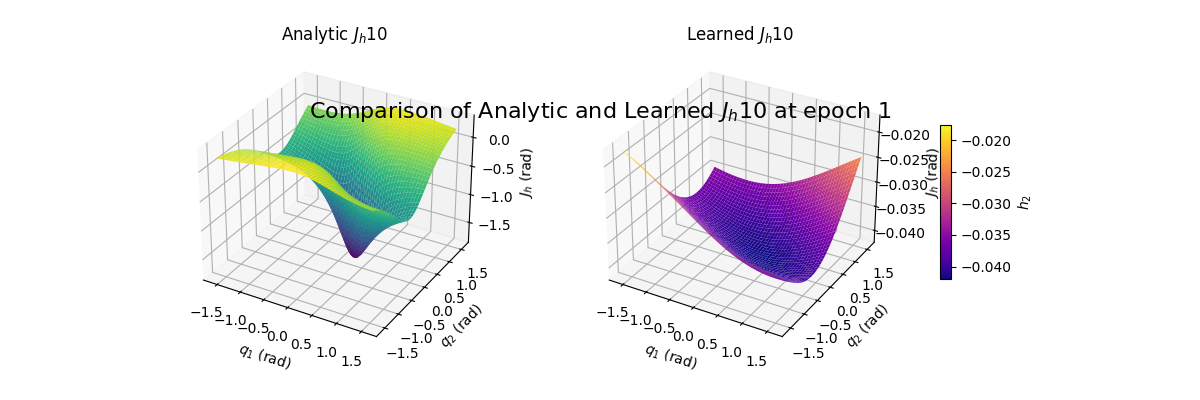

tensor(0.0018, device='cuda:0')
M_th_ratio_ana > 0.1: tensor(1., device='cuda:0')
q: tensor([-1.5708, -1.5708], device='cuda:0')
M_th_ana:
 tensor([[17.6918, 17.6918],
        [17.6918, 17.6918]], device='cuda:0')
J_h_ana:
 tensor([[-1.4142, -1.4142],
        [ 0.2000,  0.2000]], device='cuda:0')
1


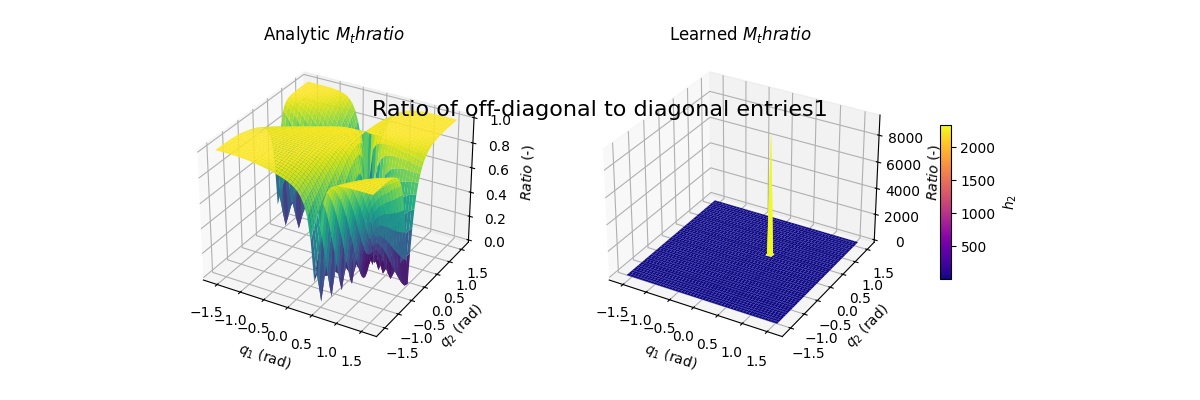

Epoch:51, Loss:0.000674296


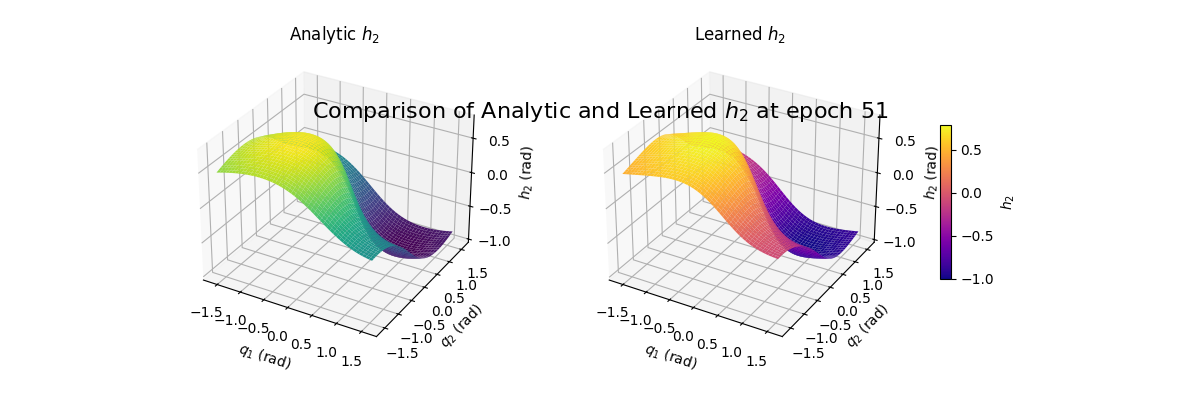

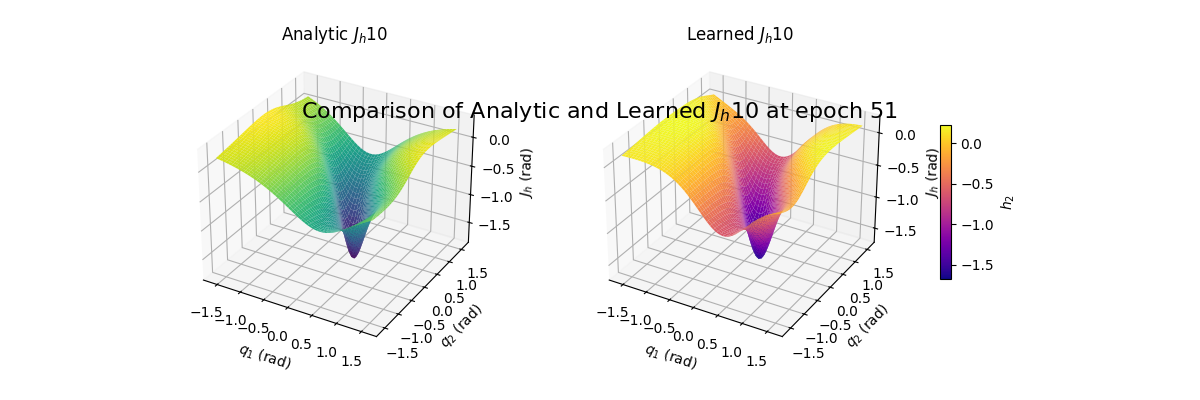

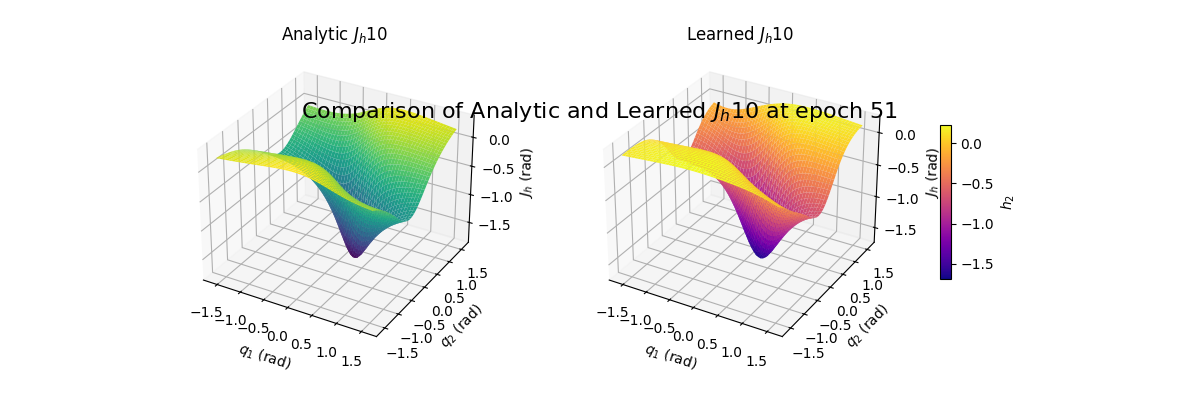

tensor(0.0018, device='cuda:0')
M_th_ratio_ana > 0.1: tensor(1., device='cuda:0')
q: tensor([-1.5708, -1.5708], device='cuda:0')
M_th_ana:
 tensor([[17.6918, 17.6918],
        [17.6918, 17.6918]], device='cuda:0')
J_h_ana:
 tensor([[-1.4142, -1.4142],
        [ 0.2000,  0.2000]], device='cuda:0')
1


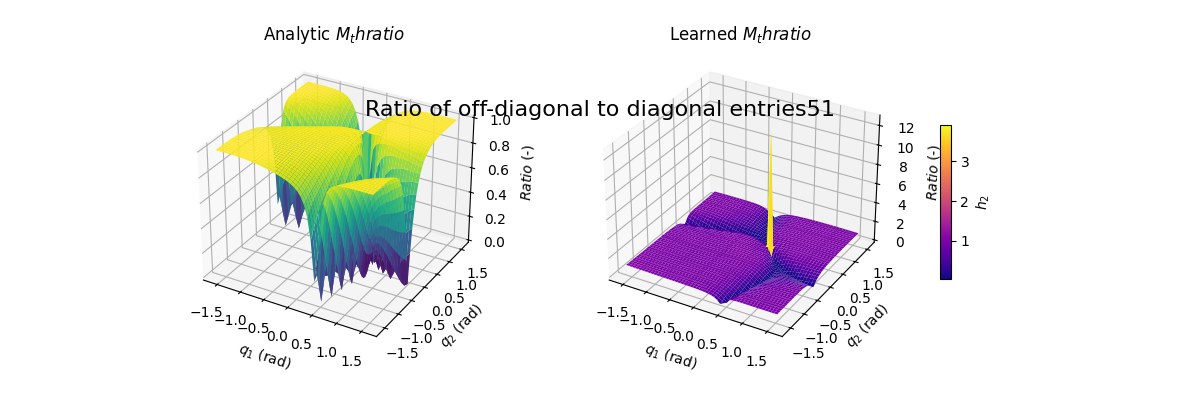

In [7]:
%%time
%matplotlib widget

current_time = datetime.now().strftime("%Y%m%d%H%M")
save_directory = os.path.join(os.getcwd(), "Models")
os.makedirs(save_directory, exist_ok=True)
file_name = f"Lumped_Mass_{current_time}.pth"
file_path = os.path.join(save_directory, file_name)

load_path = os.path.normpath("/home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Lumped_Mass_202411221331.pth")


rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 201

print(file_path)
model = Autoencoder(rp).to(device)  # Move model to GPU
#model.load_state_dict(torch.load(load_path, weights_only=True))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


l_weights = [1,
             1,
             1e-1,
             1e-2]
outputs = []


plt.ion()

for epoch in range(num_epochs):
    for index, batch in enumerate(dataloader):
        batch_size = batch[0].shape[0]
        q = batch[0][:, 0:2].to(device)
        q.requires_grad = True
        q_d = batch[0][:, 2:4].to(device)
        
        theta, J_h, q_hat, J_h_ana = model(q)  
        
        matrices_vmap = torch.vmap(dynamics.dynamical_matrices, 
                                   in_dims=(None, 0, 0))

        M_q, C_q, G_q = matrices_vmap(rp, q, q_d)
        M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h, device)      
        
        loss_reconstruction = loss_terms.loss_reconstruction(q, q_hat)
        loss_decoupling = loss_terms.loss_diagonality_geo_mean(M_th, batch_size, device)
        ### Use J@J^T = eye to avoid needing to calculate the Jacobian inverse for efficiency. 
        loss_J_h_unitary = loss_terms.loss_J_h_unitary(J_h, batch_size, device)
        loss_J_h_cheat = loss_terms.loss_J_h_cheat(J_h, J_h_ana)
        loss_M_th_cheat = loss_terms.loss_M_th_cheat(M_th, rp, q, q_d, batch_size)
        l1_norm = loss_terms.loss_l1(model)

        loss = loss_J_h_cheat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch:{epoch+1}, Loss:{loss.item():.9f}')#, LR:{scheduler.get_last_lr():.7f}')
    if epoch % 50 == 0:
        plotters.plot_h2(model, device, rp, epoch)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 0)
        plotters.plot_J_h(model, device, rp, epoch, plot_index = 1)
        plotters.plot_decoupling(model, device, rp, epoch)
    scheduler.step()
    #print("reconstruction loss:", (loss_reconstruction*l_weights[0]).item())
    #print("decoupling loss:", (loss_decoupling*l_weights[1]).item())
    #print("jacobian loss:", (loss_jacobian*l_weights[2]).item())
    #print("l1 norm loss:", (l1_norm*l_weights[3]).item())
    outputs.append((epoch, loss, q, q_hat, theta, M_th))

torch.save(model.state_dict(), file_path)
print(f"Model parameters saved to {file_path}")

tensor(0.0018, device='cuda:0')
M_th_ratio_ana > 0.1: tensor(1., device='cuda:0')
q: tensor([-1.5708, -1.5708], device='cuda:0')
M_th_ana:
 tensor([[17.6918, 17.6918],
        [17.6918, 17.6918]], device='cuda:0')
J_h_ana:
 tensor([[-1.4142, -1.4142],
        [ 0.2000,  0.2000]], device='cuda:0')
1


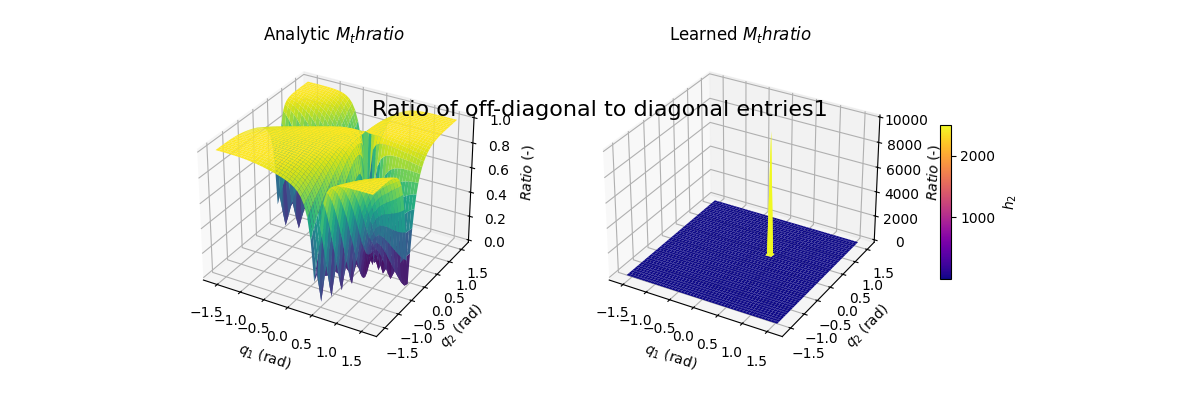

In [ ]:

plotters.plot_decoupling(model, device, rp, epoch)

In [ ]:
q_test = torch.tensor([[-0.4167, -0.4167]]).to(device)
theta, J_h, q_hat, J_h_ana = model(q_test)

J_h_inv = torch.linalg.inv(J_h)
J_h_inv_trans = J_h_inv.transpose(1, 2)




print("J_h:\n", J_h.detach().cpu().numpy()[0])
print("J_h_inv:\n", J_h_inv.detach().cpu().numpy()[0])
print("J_h_inv_trans:\n", J_h_inv_trans.detach().cpu().numpy()[0])



M_q, C_q, G_q = dynamics.dynamical_matrices(rp, q_test[0], q_test[0])
M_q = M_q.unsqueeze(0)
M_th, C_th, G_th = transforms.transform_dynamical_matrices(M_q, C_q, G_q, J_h_inv, J_h_inv_trans)
print("M_q:", M_q)
print("M_th:\n", M_th)

print("J_h_inv size:\n", J_h_inv.size())
print("J_h_inv_trans size:\n", J_h_inv_trans.size())
print("M_q size:\n", M_q.size())

off_dia = M_th[:, 1,0]
diag_elements = M_th[:, [0, 1], [0, 1]]
diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1] + 1e-6)
M_th_ratio = off_dia/diag_product
print("off_dia:\n", off_dia)
print("diag_product:", diag_product)
print("diag_elements:\n", diag_elements)
print("M_th_ratio:", M_th_ratio)

print("M_th by hand:\n", J_h_inv_trans @ M_q @ J_h_inv)

print("M_q:\n", M_q)

print("J_h_ana:\n", J_h_ana.detach().cpu().numpy()[0], "\n")
J_h_ana_inv = torch.linalg.pinv(J_h_ana)
J_h_ana_inv_trans = J_h_ana_inv.transpose(1,2)

print("J_h_ana_inv:\n", J_h_ana_inv.detach().cpu().numpy()[0], "\n")
print("J_h_ana_inv_trans:\n", J_h_ana_inv_trans.detach().cpu().numpy()[0], "\n")


M_th_ana, C_th_ana, G_th_ana = dynamics.dynamical_matrices_th(rp, q_test[0], q_test[0]) 
print(M_th_ana.detach().cpu().numpy())

J_h:
 [[-1.9967617  -1.9967617 ]
 [-0.00291013  0.00708051]]
J_h_inv:
 [[  -0.35493183 -100.093704  ]
 [  -0.1458791   100.093704  ]]
J_h_inv_trans:
 [[  -0.35493183   -0.1458791 ]
 [-100.093704    100.093704  ]]
M_q: tensor([[[12., 12.],
         [12., 12.]]], device='cuda:0')
M_th:
 tensor([[[47.9842, 47.7445],
         [47.7445, 47.5060]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)
J_h_inv size:
 torch.Size([1, 2, 2])
J_h_inv_trans size:
 torch.Size([1, 2, 2])
M_q size:
 torch.Size([1, 2, 2])
off_dia:
 tensor([47.7445], device='cuda:0', grad_fn=<SelectBackward0>)
diag_product: tensor([47.7445], device='cuda:0', grad_fn=<SqrtBackward0>)
diag_elements:
 tensor([[47.9842, 47.5060]], device='cuda:0', grad_fn=<IndexBackward0>)
M_th_ratio: tensor([1.], device='cuda:0', grad_fn=<DivBackward0>)
M_th by hand:
 tensor([[[3.0097, 0.0000],
         [0.0000, 0.0000]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)
M_q:
 tensor([[[12., 12.],
         [12., 12.]]], device='cuda:0')
J_h_ana

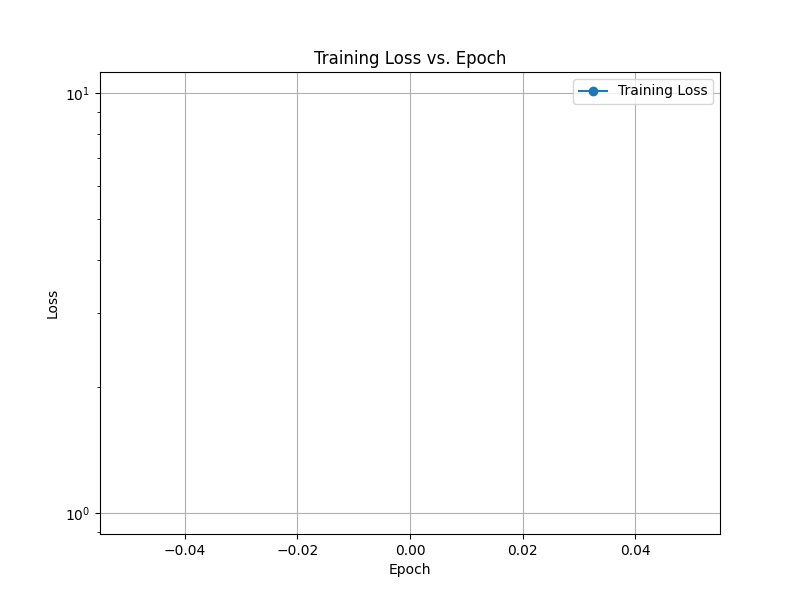

In [ ]:
# Extract epochs and losses
epochs = [entry[0] for entry in outputs]
losses = [entry[1].item() for entry in outputs]

# Plot loss as a function of epoch
plt.figure(figsize=(8, 6))
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print(M_th)
print(M_th_ana)

tensor([[[47.9842, 47.7445],
         [47.7445, 47.5060]]], device='cuda:0', grad_fn=<UnsafeViewBackward0>)
tensor([[ 3.0000,  0.0000],
        [ 0.0000, 25.9823]], device='cuda:0')


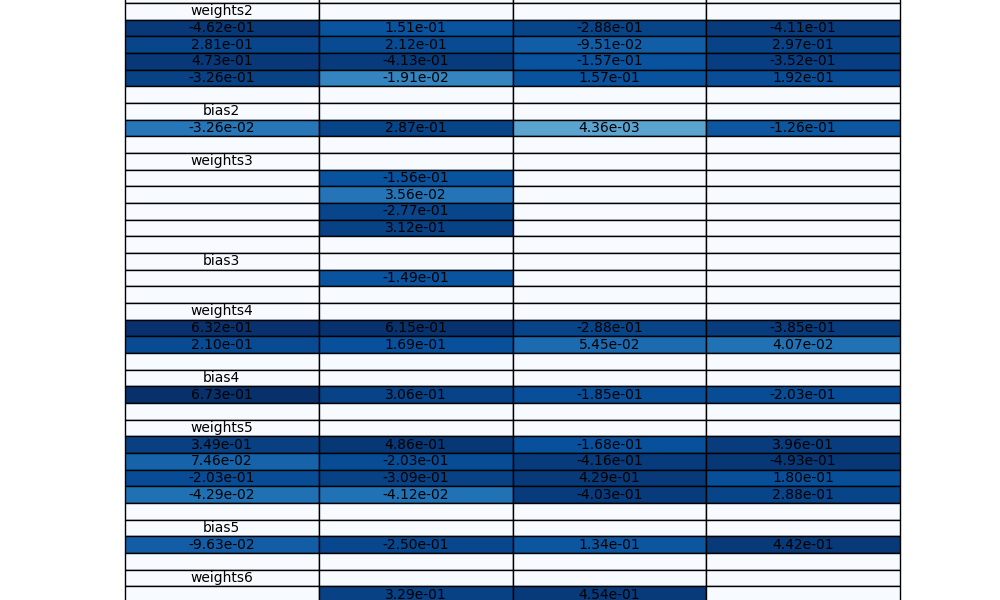

In [ ]:
import random
import string

max_neurons = 4
blank_layer = [None for _ in range(max_neurons)]

table_layers = []
for idx, param in enumerate(model.parameters()):
    layer = param.data
    num_parallel = layer.shape[0]
    side_padding = int((max_neurons - num_parallel)/2)
    
    if idx % 2 == 0:
        
        table_layer = blank_layer.copy()
        table_layer[0] = "weights" + str(idx//2+1)
        table_layers.append(table_layer)
        for i in range(layer.shape[1]):
            table_layer = blank_layer.copy()
            for j in range(num_parallel):
                table_layer[j+side_padding] = '{:.2e}'.format(layer[j][i].item())
            table_layers.append(table_layer)
        table_layers.append(blank_layer)
            
    else:  
        
        table_layer = blank_layer.copy()
        table_layer[0] = "bias" + str(idx//2+1)
        table_layers.append(table_layer)
        table_layer = blank_layer.copy()
        for j in range(num_parallel):
            table_layer[j+side_padding] = '{:.2e}'.format(layer[j].item())
        table_layers.append(table_layer)
        table_layers.append(blank_layer)

numeric_values = np.zeros((len(table_layers), max_neurons))
for i, row in enumerate(table_layers):
    for j, item in enumerate(row):
        if item not in (None, "weights1", "weights2", "bias1", "bias2"):  # Replace with relevant layer names
            try:
                numeric_values[i, j] = (float(item))
            except ValueError:
                pass
        
min_val, max_val = numeric_values.min(), numeric_values.max()


# Step 2: Apply a logarithmic transformation, setting a small threshold to avoid log(0)
threshold = 1e-5
log_values = np.log10(np.clip(np.abs(numeric_values), threshold, None))

# Normalize the log-scaled values to range between 0 and 1
normalized_values = (log_values - log_values.min()) / (log_values.max() - log_values.min())
colors = plt.cm.Blues(normalized_values)

        
# Plot the table
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = plt.table(cellText=table_layers, cellColours=colors, loc='center', cellLoc='center')

plt.show()